# TattiSketch - LoRA адаптер для стиля тату "одной линии"


# Инструкция для запуска ноутбука

Этот ноутбук выполняет:
- обучение LoRA-адаптера на датасете из 51-го эскиза тату (выполнены в стиле одной непрерывной линии) с использованием платформы Fal.ai;
- генерацию изображений на baseline-модели (fal-ai/flux/dev);
- генерацию изображений на обученном LoRA-адаптере;
- расчет, оценку и визуализацию метрик

**Для корректной работы требуется:**
- установить свой API-ключ Fal.ai через `userdata` или переменную `FAL_KEY`;
- загрузить архив `dataset.zip` с датасетом изображений в папку `/content/` в Google Colab;
- загрузить `sample_line.png` в папку `/content/dataset/` для оценки метрики Style Loss.

---


## 1. Установка зависимостей

In [1]:
!pip install fal-client requests Pillow opencv-python matplotlib pytorch-fid scikit-image torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 139.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 761.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

## 2. Настройка API и импорт библиотек


In [2]:
import fal_client
import requests
import os
import time
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import torch
import torchvision.models as models
from torchvision import transforms
from google.colab import userdata
from fal_client import Queued, InProgress, Completed

## Конфигурация


In [3]:
FAL_KEY = userdata.get('FAL_API_KEY')
os.environ["FAL_KEY"] = FAL_KEY

REFERENCE_IMAGE_PATH = "/content/dataset/sample_line.png"

## 3. Загрузка датасета

In [4]:
!mkdir -p dataset generated

- загрузить /content/dataset.zip - для обучения в Fal.ai
- загрузить /content/dataset/sample_line.png - для оценки метрики Style Loss в дальнейшем

In [15]:
data_zip_url = fal_client.upload_file("dataset.zip")
print("ZIP загружен:", data_zip_url)

ZIP загружен: https://v3.fal.media/files/penguin/hcFwLHVT-yMDQo6nVq5nr_dataset.zip


## 4. Обучение LoRA-адаптера на платформе Fal.ai


In [16]:
handler = fal_client.submit(
    "fal-ai/flux-lora-fast-training",
    arguments={
        "images_data_url": data_zip_url,
        "is_style": True,
        "steps": 3000,
        "trigger_word": "single continuous black line drawing, minimalism, no shading, no breaks",
        "create_masks": False
    }
)

while True:
    status = fal_client.status(
        "fal-ai/flux-lora-fast-training",
        handler.request_id,
        with_logs=True
    )

    if isinstance(status, Queued):
        print(f"В очереди (position={status.position})")

    elif isinstance(status, InProgress):
        for log in status.logs or []:
            print(log.get("message", "<no message>"))

    elif isinstance(status, Completed):
        print("Обучение завершено!")
        break

    else:
        raise RuntimeError(f"Unexpected status object: {status!r}")

    time.sleep(30)

result = fal_client.result("fal-ai/flux-lora-fast-training", handler.request_id)
lora_url = result["diffusers_lora_file"]["url"]
print("LoRA weights:", lora_url)

В очереди (position=0)
Archive files: 
[PosixPath('/tmp/tmpo2wx0qo9/47.png'), PosixPath('/tmp/tmpo2wx0qo9/24.png'), PosixPath('/tmp/tmpo2wx0qo9/39.png'), PosixPath('/tmp/tmpo2wx0qo9/12.png'), PosixPath('/tmp/tmpo2wx0qo9/16.png'), PosixPath('/tmp/tmpo2wx0qo9/7.png'), PosixPath('/tmp/tmpo2wx0qo9/40.png'), PosixPath('/tmp/tmpo2wx0qo9/19.png'), PosixPath('/tmp/tmpo2wx0qo9/27.png'), PosixPath('/tmp/tmpo2wx0qo9/1.png'), PosixPath('/tmp/tmpo2wx0qo9/4.png'), PosixPath('/tmp/tmpo2wx0qo9/46.png'), PosixPath('/tmp/tmpo2wx0qo9/13.png'), PosixPath('/tmp/tmpo2wx0qo9/15.png'), PosixPath('/tmp/tmpo2wx0qo9/32.png'), PosixPath('/tmp/tmpo2wx0qo9/42.png'), PosixPath('/tmp/tmpo2wx0qo9/31.png'), PosixPath('/tmp/tmpo2wx0qo9/25.png'), PosixPath('/tmp/tmpo2wx0qo9/48.png'), PosixPath('/tmp/tmpo2wx0qo9/44.png'), PosixPath('/tmp/tmpo2wx0qo9/23.png'), PosixPath('/tmp/tmpo2wx0qo9/30.png'), PosixPath('/tmp/tmpo2wx0qo9/22.png'), PosixPath('/tmp/tmpo2wx0qo9/18.png'), PosixPath('/tmp/tmpo2wx0qo9/3.png'), PosixPath('/tm

Файл весов обученного LoRA-адаптера:

In [17]:
lora_url = "https://v3.fal.media/files/penguin/O1_RKyPsRx0phG9Dpy65P_pytorch_lora_weights.safetensors"

## 5. Генерация изображений:
- baseline - fal-ai/flux/dev;
- lora - fal-ai/flux/dev + LoRA ( + триггер)

In [18]:
MODEL_SLUG = "fal-ai/flux/dev"

prompts = ["rat", "dragon", "airplane"]

def generate_image(prompt, use_lora=False):
    arguments = {
        "prompt": prompt,
        "image_size": {"width": 512, "height": 512}
    }

    if use_lora:

        arguments["prompt"] = f"{prompt} <single continuous black line drawing, minimalism, no shading, no breaks>"
        arguments["lora_urls"] = [lora_url]

    response = fal_client.run(MODEL_SLUG, arguments=arguments)
    img_data = requests.get(response["images"][0]["url"], stream=True)
    return Image.open(img_data.raw).convert("RGB")

for i, prompt in enumerate(prompts):
    # Генерация без LoRA (Baseline)
    img_baseline = generate_image(prompt, use_lora=False)
    img_baseline.save(f"generated/baseline_{i}.png")

    # Генерация с LoRA (Стиль одной линии)
    img_lora = generate_image(prompt, use_lora=True)
    img_lora.save(f"generated/lora_{i}.png")


## 6. Метрики качества:

In [20]:
reference_img = Image.open(REFERENCE_IMAGE_PATH)

vgg = models.vgg19(pretrained=True).features.eval()

def gram_matrix(input):
    batch_size, depth, h, w = input.size()
    features = input.view(batch_size * depth, h * w)
    return torch.mm(features, features.t()) / (batch_size * depth * h * w)

def style_loss(generated, reference):

    generated = generated.convert("RGB")
    reference = reference.convert("RGB")

    preprocess = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])
    gen_tensor = preprocess(generated).unsqueeze(0)
    ref_tensor = preprocess(reference).unsqueeze(0)
    gen_features = vgg(gen_tensor)
    ref_features = vgg(ref_tensor)
    return torch.mean((gram_matrix(gen_features) - gram_matrix(ref_features))**2)

metrics = {"Baseline": {"EC": [], "LCI": [], "StyleLoss": [], "HSS": []},
           "LoRA": {"EC": [], "LCI": [], "StyleLoss": [], "HSS": []}}

for i in range(len(prompts)):
    baseline_img = Image.open(f"generated/baseline_{i}.png")
    lora_img = Image.open(f"generated/lora_{i}.png")

    metrics["Baseline"]["EC"].append(len(cv2.findContours(
        cv2.Canny(cv2.cvtColor(np.array(baseline_img), cv2.COLOR_RGB2GRAY), 50, 200),
        cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )[0]))

    metrics["LoRA"]["EC"].append(len(cv2.findContours(
        cv2.Canny(cv2.cvtColor(np.array(lora_img), cv2.COLOR_RGB2GRAY), 50, 200),
        cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )[0]))

    metrics["Baseline"]["LCI"].append(len(cv2.goodFeaturesToTrack(
        cv2.cvtColor(np.array(baseline_img), cv2.COLOR_RGB2GRAY),
        maxCorners=50, qualityLevel=0.005, minDistance=5
    )))

    metrics["LoRA"]["LCI"].append(len(cv2.goodFeaturesToTrack(
        cv2.cvtColor(np.array(lora_img), cv2.COLOR_RGB2GRAY),
        maxCorners=50, qualityLevel=0.005, minDistance=5
    )))

    metrics["Baseline"]["StyleLoss"].append(style_loss(baseline_img, reference_img).item())
    metrics["LoRA"]["StyleLoss"].append(style_loss(lora_img, reference_img).item())

print("Введите Human Style Scores от 1 до 5 для каждого изображения:")
for model in ["Baseline", "LoRA"]:
    for i, prompt in enumerate(prompts):
        score = float(input(f"{model} - {prompt}: "))
        metrics[model]["HSS"].append(score)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Введите Human Style Scores от 1 до 5 для каждого изображения:
Baseline - rat: 1
Baseline - dragon: 1
Baseline - airplane: 1
LoRA - rat: 2
LoRA - dragon: 2
LoRA - airplane: 2


## Значения метрик:

In [21]:
def print_metrics(metrics_dict):
    for model_name, model_metrics in metrics_dict.items():
        print(f"\n=== {model_name} ===")
        for metric_name, values in model_metrics.items():
            mean_val = np.mean(values)
            std_val  = np.std(values)
            print(f"{metric_name:12s}: mean = {mean_val:.4e}, std = {std_val:.4e}")

print_metrics(metrics)


=== Baseline ===
EC          : mean = 5.4533e+02, std = 2.3547e+02
LCI         : mean = 5.0000e+01, std = 0.0000e+00
StyleLoss   : mean = 3.3412e-07, std = 1.4477e-07
HSS         : mean = 1.0000e+00, std = 0.0000e+00

=== LoRA ===
EC          : mean = 2.0533e+02, std = 6.7371e+01
LCI         : mean = 5.0000e+01, std = 0.0000e+00
StyleLoss   : mean = 6.3915e-08, std = 2.0553e-08
HSS         : mean = 2.0000e+00, std = 0.0000e+00


## 7. Визуализация результатов:

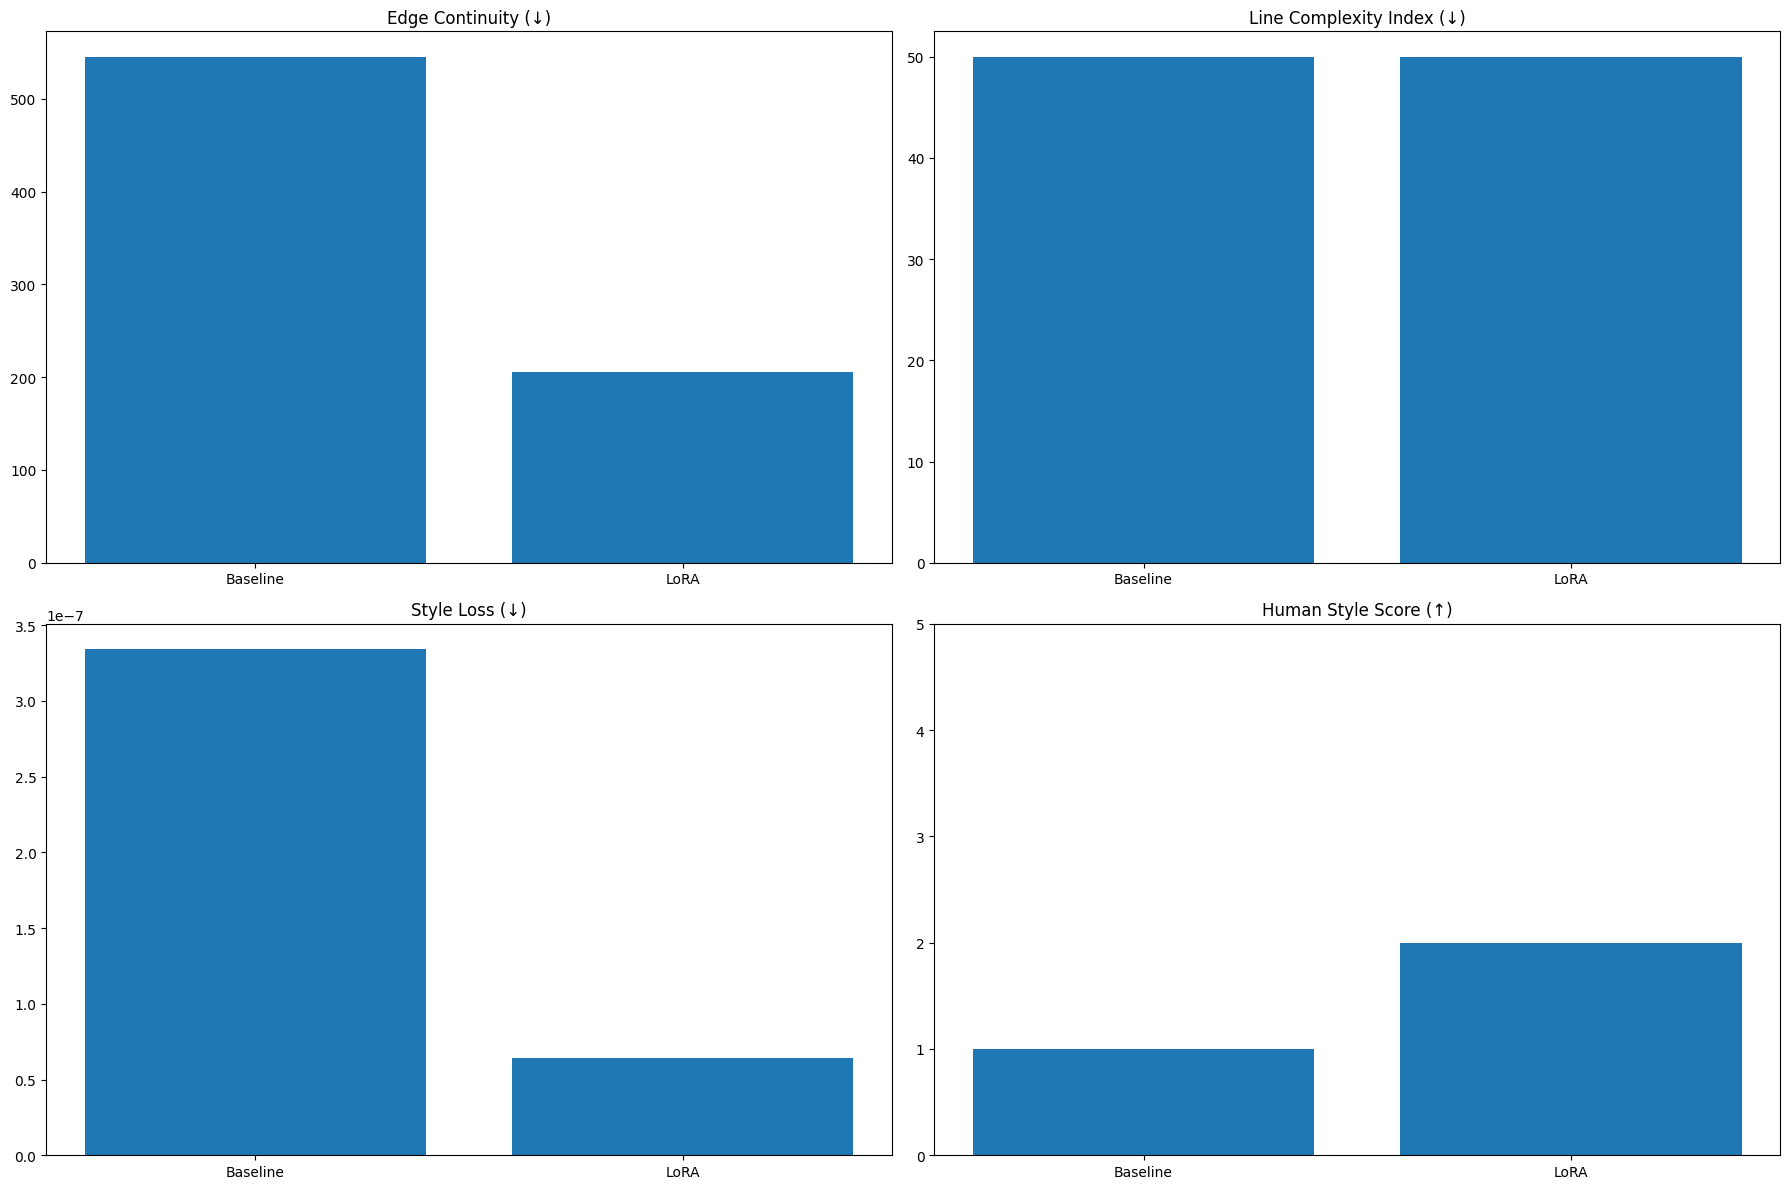

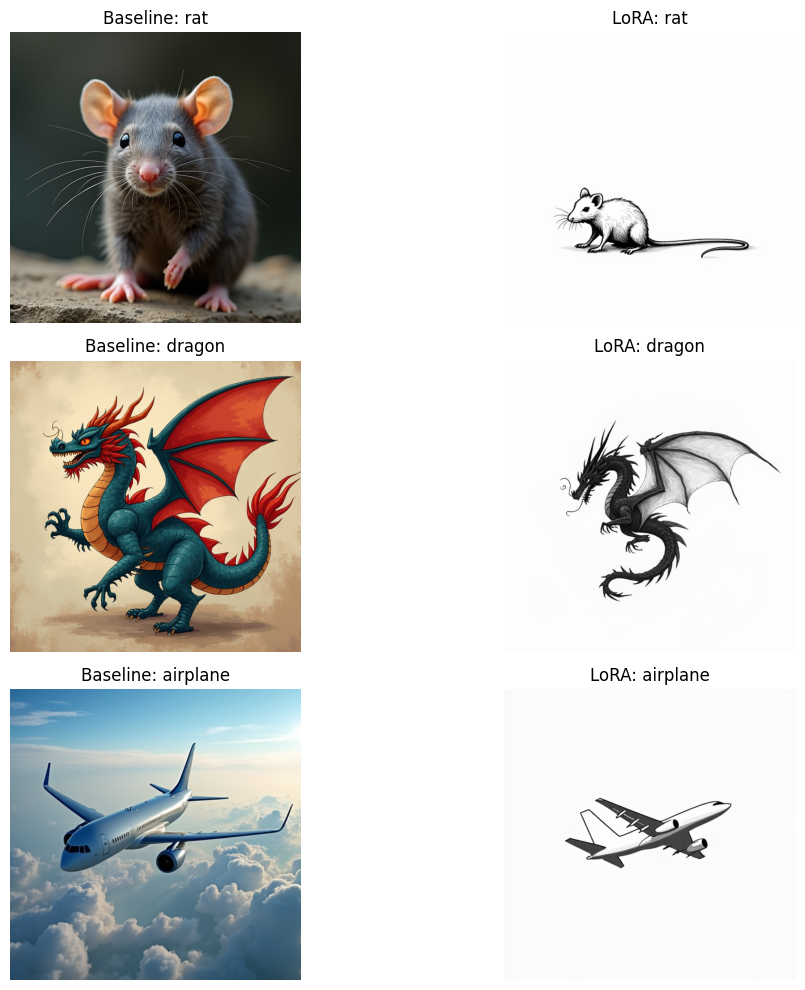

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

axs[0, 0].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["EC"]), np.mean(metrics["LoRA"]["EC"])])
axs[0, 0].set_title("Edge Continuity (↓)")

axs[0, 1].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["LCI"]), np.mean(metrics["LoRA"]["LCI"])])
axs[0, 1].set_title("Line Complexity Index (↓)")

axs[1, 0].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["StyleLoss"]), np.mean(metrics["LoRA"]["StyleLoss"])])
axs[1, 0].set_title("Style Loss (↓)")

axs[1, 1].bar(["Baseline", "LoRA"], [np.mean(metrics["Baseline"]["HSS"]), np.mean(metrics["LoRA"]["HSS"])])
axs[1, 1].set_title("Human Style Score (↑)")
axs[1, 1].set_ylim(0, 5)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(len(prompts), 2, figsize=(12, 10))
for i in range(len(prompts)):
    ax[i,0].imshow(Image.open(f"generated/baseline_{i}.png"))
    ax[i,0].set_title(f"Baseline: {prompts[i]}")
    ax[i,0].axis("off")

    ax[i,1].imshow(Image.open(f"generated/lora_{i}.png"))
    ax[i,1].set_title(f"LoRA: {prompts[i]}")
    ax[i,1].axis("off")

plt.tight_layout()
plt.show()


### Вывод: результаты стали значительно ближе к стилистике скетча (эскиза тату), но реализации техники "одной линией" пока не достигнуто.

**Причина:**
- Fal-ai/flux — это базовый text-to-image движок - он не был специально натренирован на следование правилам "одной линии", и полученные веса LoRA не позволяют достичь требуемого результата.

**Предложения по улучшению результата:**
- Улучшить датасет: взять не 51, а, например, 200 референсов, где именно одна линия без разрывов (без шумов, без фона, без теней, все изображения одинакового размера и черно-белые).

- Тренировать больше шагов: 5000 шагов дадут лучшее закрепление.

### Пояснения по метрикам:

Для количественной оценки ключевых аспектов стиля выполнения эскиза тату "одной линией" выбраны следующие метрики:
1. Edge Continuity (EC) - измеряет количество разрывов/сегментов в линиях эскиза. В технике «одной линии» непрерывность — ключевой критерий. Чем меньше сегментов, тем ближе к идеалу.
2. Line Complexity Index (LCI) - измеряет сложность линий (количество углов, изгибов). Стиль "одной линии" предполагает простые линии без избыточных деталей - минимализм. Чем меньше углов, тем лучше.
3. Style Loss - измеряет стилевое сходство с эталоном через нейросеть (сравнение Gram-матриц признаков VGG-19). Оценивает глубинные паттерны (плавность линий, распределение деталей), которые не улавливают EC и LCI. Чем меньше значение, тем ближе стиль.
4. Human Style Score (HSS) - измеряет субъективную оценку соответствия стилю (1–5 баллов). Численные метрики могут не отражать человеческое восприятие. Помогает выявить случаи, когда технически хороший результат «не выглядит как стиль мастера».

### Определение оптимальных параметров для EC и LCI по эталонным изображениям, выполненным в стиле тату "одной линии":

In [19]:
import itertools
import pandas as pd

# Папка с эталонными изображениями
REFS_DIR = "dataset/refs"

# Считываем все пути к изображениям
ref_files = [
    os.path.join(REFS_DIR, f)
    for f in os.listdir(REFS_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

# Диапазоны параметров для перебора
canny_lows = [10, 20, 30, 40, 50]
canny_highs = [80, 100, 120, 150, 200]
qualityLevels = [0.005, 0.01, 0.02, 0.05]
minDistances = [5, 10, 20]
maxCorners = [50, 100, 200]

# Целевое количество углов (примерная оценка для одного контура)
TARGET_CORNERS = 50

results = []

# Перебираем все комбинации параметров
for can_low, can_high, ql, md, mc in itertools.product(
    canny_lows, canny_highs, qualityLevels, minDistances, maxCorners
):
    total_ec_error = 0
    total_lci_error = 0

    for path in ref_files:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Edge Continuity: ожидаем 1 контур
        edges = cv2.Canny(img, can_low, can_high)
        contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        total_ec_error += abs(len(contours) - 1)

        # Line Complexity Index: ожидаем около TARGET_CORNERS углов
        corners = cv2.goodFeaturesToTrack(
            img,
            maxCorners=mc,
            qualityLevel=ql,
            minDistance=md
        )
        count = corners.shape[0] if corners is not None else 0
        total_lci_error += abs(count - TARGET_CORNERS)

    # Сохраняем результаты
    results.append({
        'canny_low': can_low,
        'canny_high': can_high,
        'qualityLevel': ql,
        'minDistance': md,
        'maxCorners': mc,
        'ec_error': total_ec_error,
        'lci_error': total_lci_error,
        'total_error': total_ec_error + total_lci_error
    })

# Создаём DataFrame
df = pd.DataFrame(results)

# Сортируем и выводим топ-10 лучших комбинаций параметров
top10 = df.nsmallest(10, 'total_error')
print("Top-10 лучших комбинаций параметров:")
print(top10)

# Печать лучшей комбинации
best = df.nsmallest(1, 'total_error').iloc[0]
print("\nЛучшие параметры для использования:")
for k, v in best.items():
    print(f"{k}: {v}")


Top-10 лучших комбинаций параметров:
     canny_low  canny_high  qualityLevel  minDistance  maxCorners  ec_error  \
864         50         200         0.005            5          50      1195   
867         50         200         0.005           10          50      1195   
873         50         200         0.010            5          50      1195   
684         40         200         0.005            5          50      1196   
687         40         200         0.005           10          50      1196   
693         40         200         0.010            5          50      1196   
504         30         200         0.005            5          50      1201   
507         30         200         0.005           10          50      1201   
513         30         200         0.010            5          50      1201   
144         10         200         0.005            5          50      1202   

     lci_error  total_error  
864          0         1195  
867          0         1195  
873

canny_low | 50.0 | Нижний порог для детектора границ Canny

canny_high | 200.0 | Верхний порог для детектора Canny

qualityLevel | 0.005 | Минимальная необходимая контрастность угла в детекторе Shi-Tomasi

minDistance | 5.0 | Минимальная дистанция между найденными углами

maxCorners |  50.0 | Максимальное число углов, которые нужно найти

ec_error | 1195.0 | Суммарная ошибка по количеству контуров (на всех эталонах)

lci_error | 0.0 | Идеальное соответствие по количеству углов (50 на каждом эталоне!)

total_error | 1195.0 | Сумма ошибок: EC + LCI